In [2]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from pandas import DataFrame
import statistics
import plotly
import plotly.express as px
import plotly.graph_objs as go
import sklearn
from sklearn.cluster import KMeans
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import statsmodels.api as sm

In [3]:
def do_pca(X_df, n_components=20, centered=True):

    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
   
    '''
        Return:
            W: PCA loadings for each feature (how much each feature contributes to each PC)
            Xproj: projected data in PCA space (component scores, reduced dimension representation of data)
            fracs: Fraction of data explained by each principal component in a vector
    '''
    n_features = X_df.shape[1] # Original data dimension (no of features)
    if n_components > n_features:
        n_components = n_features
    if isinstance(X_df, pd.DataFrame):
        X = X_df.values # Get the data matrix from the X_df dataframe
    if centered:            
        X = X.astype('float')  # Since X is object
        X = X - X.mean(0)
        X = X/X.std(0)
    pca = PCA(n_components=n_components) # run the PCA algorithm from sklearn on data X
    pca.fit(X)
    fracs = pca.explained_variance_ratio_  # vector with explained variance for each principal component (PC)
    Xproj = pca.fit_transform(X)   # Low-dim projection (aka Scores) - n_sample, n_redim
    W_l = pca.components_            # PC Loadings - n_redim, n_feature
    # construct two DataFrames for later use
    # Loadings in a dataframe
    W_df = pd.DataFrame(W_l, index=['PC' + str(i) for i in np.arange(1, W_l.shape[0]+1)], columns=X_df.columns.values)
    # Low-dimensional projection of data in a dataframe
    Xproj_df = pd.DataFrame(Xproj, index=X_df.index, columns=['PC'+str(i) for i in np.arange(1, Xproj.shape[1]+1)])
    W = W_df.T
    return W, Xproj_df, fracs

In [4]:
def pca_biplot(W, scores, data, topN=None, XPC='PC1', YPC='PC2', feature=None):
    import plotly
    import plotly.express as px
    import plotly.express as px
    import pandas as pd
    import numpy as np
    FeaturePCMagnitudes = W.loc[:,XPC]**2+W.loc[:,YPC]**2 # Squared length of vectors in the 2D PCA space
    FeaturePCMagnitudes.sort_values(inplace=True, ascending=False) # Sort from largest to smallest
    topN = 15 # Only show the 15 largest feature vectors

    if feature == None:
        fig = px.scatter(scores, x=XPC, y=YPC, color='label') # default is to plot the classes
        fig.update_traces(mode='markers', marker_line_width=1, marker_size=8)
    else:                               # otherwise plot the feature given in the function argument
        fig = go.Figure()
        tmp = np.array([feature + " "]*len(data))
        markertext = list()
        for i in range (1,len(data)):
            markertext.append(tmp[i] + str(data[feature].values[i]))
        fig.add_trace(go.Scatter(name="Data point",x=scores.loc[:,XPC],y=scores.loc[:,YPC],text = markertext,marker=dict(line_width=1,size=8,color=data.loc[:,feature],colorbar=dict(title=feature,x=-0.2,y=0.5),colorscale="Viridis"),mode="markers"))
        fig.update_layout(xaxis_title=XPC, yaxis_title=YPC)
    for i, g in enumerate(FeaturePCMagnitudes.iteritems()):
        if(topN is not None and i >= topN):
            continue
        fig.add_scatter(x=[0,W.loc[g[0],XPC]*2.5],y=[0,W.loc[g[0],YPC]*2.5],mode='lines',name=g[0])

    return fig

In [34]:
names = pd.read_csv(r'/Users/katemeeson/august_2022/sample_info.csv')
names

,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
1,ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN
3,ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN,Female,ATCC,CVCL_0993,NaN,...,NaN,NaN,2D: adherent,NaN,NaN,PT-rTUVZQ,NaN,Melanoma,C3224,NaN
4,ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_WS59,NaN,...,NaN,NaN,NaN,immortalized,NaN,PT-qWYYgr,NaN,NaN,NaN,No information is available about this cell li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,ACH-002393,CRO-AP3,CROAP3,CROAP3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,Sanger,CVCL_1810,NaN,...,b_cell_primary_effusion,NaN,NaN,NaN,NaN,PT-TC0lZM,NaN,Primary effusion lymphoma,C6915,NaN
1836,ACH-002394,GEO,GEO,GEO_LARGE_INTESTINE,NaN,NaN,NaN,Sanger,CVCL_0271,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-Fa1q9q,NaN,Colon carcinoma,C4910,NaN
1837,ACH-002395,HuH-6 Clone 5,HUH6CLONE5,HUH6CLONE5_LIVER,NaN,NaN,Male,Sanger,CVCL_1296,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-TtIXsL,ACH-000671,Hepatoblastoma,C3728,NaN
1838,ACH-002396,Sarc9371,SARC9371,SARC9371_BONE,NaN,NaN,NaN,Sanger,CVCL_5G89,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-715FdC,NaN,Osteosarcoma,C9145,NaN


In [32]:
ccle = pd.read_csv(r'/Users/katemeeson/Downloads/CCLE_expression_full (4).csv')
ccle = ccle.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
ccle #this needs updating with the new file as more cell lines have been added 

,Unnamed: 0,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
0,ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,...,0.000000,0.536053,0.000000,0.028569,0.176323,0.992768,2.794936,0.000000,0.0,0.000000
1,ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,...,0.000000,0.879706,0.000000,0.014355,0.014355,0.432959,2.972693,0.056584,0.0,0.070389
2,ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,...,0.028569,0.000000,0.084064,0.000000,0.097611,0.367371,1.695994,0.084064,0.0,0.000000
3,ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,...,0.000000,0.000000,0.070389,0.000000,0.176323,0.411426,3.921246,0.028569,0.0,0.000000
4,ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,...,0.000000,0.000000,0.201634,0.028569,0.137504,0.678072,4.418190,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,...,0.000000,0.000000,0.000000,0.056584,0.298658,1.244887,4.553975,0.056584,0.0,0.000000
1402,ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,...,0.000000,0.575312,0.807355,0.000000,0.163499,0.454176,5.377818,0.310340,0.0,0.000000
1403,ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,...,0.014355,0.000000,0.226509,0.014355,0.028569,0.695994,4.456806,0.367371,0.0,0.000000
1404,ACH-001997,5.057017,0.000000,7.814935,2.538538,3.893362,0.028569,4.078951,6.971429,4.469886,...,0.000000,0.000000,0.084064,0.000000,0.214125,0.604071,4.196135,0.084064,0.0,0.028569


In [35]:
ccle_ids = []
for n in range(len(ccle['Unnamed: 0'])):
    for num in range(len(names['DepMap_ID'])):
        if ccle.iloc[n,0] in names.iloc[num,0]:
            ccle_ids.append(names.iloc[num,3])
print(ccle_ids)

['LC1SQSF_LUNG', 'COGAR359_SOFT_TISSUE', 'COLO794_SKIN', 'KKU213_BILIARY_TRACT', 'RT4_URINARY_TRACT', 'SNU283_LARGE_INTESTINE', 'NCIH1395_LUNG', 'DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'SNU1196_BILIARY_TRACT', 'LC1F_LUNG', '93T449_SOFT_TISSUE', 'TGBC18TKB_LARGE_INTESTINE', 'ABC1_LUNG', 'SKN_ENDOMETRIUM', 'KE97_STOMACH', 'BFTC909_KIDNEY', 'KCIMOH1_PANCREAS', 'YKG1_CENTRAL_NERVOUS_SYSTEM', 'MKN1_STOMACH', 'LK2_LUNG', 'HS888T_FIBROBLAST', 'ZR7530_BREAST', 'SW837_LARGE_INTESTINE', 'WM983B_SKIN', 'PACADD119_PANCREAS', 'A101D_SKIN', 'OS252_BONE', 'NCIH446_LUNG', 'PECAPJ34CLONEC12_UPPER_AERODIGESTIVE_TRACT', 'TUHR14TKB_KIDNEY', 'COV434_OVARY', 'YD10B_UPPER_AERODIGESTIVE_TRACT', 'HSSCH2_CENTRAL_NERVOUS_SYSTEM', 'KKU100_BILIARY_TRACT', 'KMRC3_KIDNEY', 'HOKUG_CERVIX', 'KASUMI2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'NCIH2882_LUNG', 'KYSE140_OESOPHAGUS', 'MKN7_STOMACH', 'MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'SAS_UPPER_AERODIGESTIVE_TRACT', 'PACADD137_PANCREAS', 'L428_HAEMATOPOIETIC_AND_L

In [36]:
names = []
for n in ccle_ids:
    names.append(n)
print(names)

['LC1SQSF_LUNG', 'COGAR359_SOFT_TISSUE', 'COLO794_SKIN', 'KKU213_BILIARY_TRACT', 'RT4_URINARY_TRACT', 'SNU283_LARGE_INTESTINE', 'NCIH1395_LUNG', 'DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'SNU1196_BILIARY_TRACT', 'LC1F_LUNG', '93T449_SOFT_TISSUE', 'TGBC18TKB_LARGE_INTESTINE', 'ABC1_LUNG', 'SKN_ENDOMETRIUM', 'KE97_STOMACH', 'BFTC909_KIDNEY', 'KCIMOH1_PANCREAS', 'YKG1_CENTRAL_NERVOUS_SYSTEM', 'MKN1_STOMACH', 'LK2_LUNG', 'HS888T_FIBROBLAST', 'ZR7530_BREAST', 'SW837_LARGE_INTESTINE', 'WM983B_SKIN', 'PACADD119_PANCREAS', 'A101D_SKIN', 'OS252_BONE', 'NCIH446_LUNG', 'PECAPJ34CLONEC12_UPPER_AERODIGESTIVE_TRACT', 'TUHR14TKB_KIDNEY', 'COV434_OVARY', 'YD10B_UPPER_AERODIGESTIVE_TRACT', 'HSSCH2_CENTRAL_NERVOUS_SYSTEM', 'KKU100_BILIARY_TRACT', 'KMRC3_KIDNEY', 'HOKUG_CERVIX', 'KASUMI2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'NCIH2882_LUNG', 'KYSE140_OESOPHAGUS', 'MKN7_STOMACH', 'MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'SAS_UPPER_AERODIGESTIVE_TRACT', 'PACADD137_PANCREAS', 'L428_HAEMATOPOIETIC_AND_L

In [48]:
names_2 = names[0:553]
names_3 = names[554:]
names_4 = []
for n in names_2:
    names_4.append(n)
for n in names_3:
    names_4.append(n)
    
names_6 = names_4[0:882]
names_7 = names_4[883:]
names_5 = []
for n in names_6:
    names_5.append(n)
for n in names_7:
    names_5.append(n)

In [49]:
colour_map = {}
for n in names_5:
    if 'BREAST' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[0]
    elif 'SKIN' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[1]
    elif 'KIDNEY' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[2]
    elif 'LUNG' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[3]
    elif 'LIVER' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[4]
    elif 'OVARY' in n:
        colour_map[n] = 'black'
    elif 'URINARY_TRACT' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[6]
    elif 'PANCREAS' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[7]
    elif 'LARGE_INTESTINE' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[8]
    elif 'STOMACH' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[0]
    elif 'UPPER_AERODIGESTIVE' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel1[5]
    elif 'OESOPHAGUS' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[1]
    elif 'PROSTATE' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[2]
    elif 'BONE' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[3]
    elif 'SOFT_TISSUE' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[4]
    elif 'HAEMATOPOIETIC_AND' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[5]
    elif 'CENTRAL_NERVOUS' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[6]
    elif 'ENDOMETRIUM' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[7]
    elif 'AUTONOMIC_GANGLIA' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[8]
    elif 'PLEURA' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[9]
    elif 'THYROID' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[10]
    elif 'BILIARY_TRACT' in n:
        colour_map[n] = plotly.colors.qualitative.Set3[11]
    elif 'FIBROBLAST' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[0]
    elif 'CERVIX' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[1]
    elif 'EYE' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[2]
    elif 'PRIMARY' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[3]
    elif 'UVEA' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[4]
    elif 'ENGINEERED' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[5]
    elif 'Melanoma_Skin' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[6]
    elif 'Osteosarcoma' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[7]
    elif 'SALIVARY_GLAND' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[8]
    elif 'TESTIS' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[9]
    elif 'SMALL_INTESTINE' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel[10]
    elif 'Brain' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel2[0]
    elif 'PLACENTA' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel2[1]
    elif 'COLON' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel2[3]
    elif 'Melanoma_Eye' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel2[4]
    elif 'ADRENAL_CORTEX' in n:
        colour_map[n] = plotly.colors.qualitative.Pastel2[5]
    else:
        print(n)
print(colour_map)

{'LC1SQSF_LUNG': 'rgb(222,203,228)', 'COGAR359_SOFT_TISSUE': 'rgb(128,177,211)', 'COLO794_SKIN': 'rgb(179,205,227)', 'KKU213_BILIARY_TRACT': 'rgb(255,237,111)', 'RT4_URINARY_TRACT': 'rgb(229,216,189)', 'SNU283_LARGE_INTESTINE': 'rgb(242,242,242)', 'NCIH1395_LUNG': 'rgb(222,203,228)', 'DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE': 'rgb(253,180,98)', 'SNU1196_BILIARY_TRACT': 'rgb(255,237,111)', 'LC1F_LUNG': 'rgb(222,203,228)', '93T449_SOFT_TISSUE': 'rgb(128,177,211)', 'TGBC18TKB_LARGE_INTESTINE': 'rgb(242,242,242)', 'ABC1_LUNG': 'rgb(222,203,228)', 'SKN_ENDOMETRIUM': 'rgb(252,205,229)', 'KE97_STOMACH': 'rgb(141,211,199)', 'BFTC909_KIDNEY': 'rgb(204,235,197)', 'KCIMOH1_PANCREAS': 'rgb(253,218,236)', 'YKG1_CENTRAL_NERVOUS_SYSTEM': 'rgb(179,222,105)', 'MKN1_STOMACH': 'rgb(141,211,199)', 'LK2_LUNG': 'rgb(222,203,228)', 'HS888T_FIBROBLAST': 'rgb(102, 197, 204)', 'ZR7530_BREAST': 'rgb(251,180,174)', 'SW837_LARGE_INTESTINE': 'rgb(242,242,242)', 'WM983B_SKIN': 'rgb(179,205,227)', 'PACADD119_PANCREAS'

In [50]:
len(colour_map)

1404

In [51]:
ccle['cell_line'] = ccle_ids
ccle = ccle.set_index(['cell_line'])
ccle

,Unnamed: 0,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
cell_line,,,,,,,,,,,,,,,,,,,,,
LC1SQSF_LUNG,ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,...,0.000000,0.536053,0.000000,0.028569,0.176323,0.992768,2.794936,0.000000,0.0,0.000000
COGAR359_SOFT_TISSUE,ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,...,0.000000,0.879706,0.000000,0.014355,0.014355,0.432959,2.972693,0.056584,0.0,0.070389
COLO794_SKIN,ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,...,0.028569,0.000000,0.084064,0.000000,0.097611,0.367371,1.695994,0.084064,0.0,0.000000
KKU213_BILIARY_TRACT,ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,...,0.000000,0.000000,0.070389,0.000000,0.176323,0.411426,3.921246,0.028569,0.0,0.000000
RT4_URINARY_TRACT,ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,...,0.000000,0.000000,0.201634,0.028569,0.137504,0.678072,4.418190,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,...,0.000000,0.000000,0.000000,0.056584,0.298658,1.244887,4.553975,0.056584,0.0,0.000000
KP363T_COLON,ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,...,0.000000,0.575312,0.807355,0.000000,0.163499,0.454176,5.377818,0.310340,0.0,0.000000
SSP25_BILIARY_TRACT,ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,...,0.014355,0.000000,0.226509,0.014355,0.028569,0.695994,4.456806,0.367371,0.0,0.000000


In [52]:
ccle_2 = ccle.iloc[:,1:]
ccle_2

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
cell_line,,,,,,,,,,,,,,,,,,,,,
LC1SQSF_LUNG,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,0.000000,0.536053,0.000000,0.028569,0.176323,0.992768,2.794936,0.000000,0.0,0.000000
COGAR359_SOFT_TISSUE,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,0.000000,0.879706,0.000000,0.014355,0.014355,0.432959,2.972693,0.056584,0.0,0.070389
COLO794_SKIN,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.028569,0.000000,0.084064,0.000000,0.097611,0.367371,1.695994,0.084064,0.0,0.000000
KKU213_BILIARY_TRACT,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.000000,0.000000,0.070389,0.000000,0.176323,0.411426,3.921246,0.028569,0.0,0.000000
RT4_URINARY_TRACT,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,0.000000,0.000000,0.201634,0.028569,0.137504,0.678072,4.418190,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,5.178715,...,0.000000,0.000000,0.000000,0.056584,0.298658,1.244887,4.553975,0.056584,0.0,0.000000
KP363T_COLON,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,4.397118,...,0.000000,0.575312,0.807355,0.000000,0.163499,0.454176,5.377818,0.310340,0.0,0.000000
SSP25_BILIARY_TRACT,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,3.401903,...,0.014355,0.000000,0.226509,0.014355,0.028569,0.695994,4.456806,0.367371,0.0,0.000000


In [53]:
ccle_2 = ccle_2.loc[:, (ccle_2 != 0).any(axis=0)]
ccle_2

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
cell_line,,,,,,,,,,,,,,,,,,,,,
LC1SQSF_LUNG,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,0.000000,0.536053,0.000000,0.028569,0.176323,0.992768,2.794936,0.000000,0.0,0.000000
COGAR359_SOFT_TISSUE,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,0.000000,0.879706,0.000000,0.014355,0.014355,0.432959,2.972693,0.056584,0.0,0.070389
COLO794_SKIN,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.028569,0.000000,0.084064,0.000000,0.097611,0.367371,1.695994,0.084064,0.0,0.000000
KKU213_BILIARY_TRACT,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.000000,0.000000,0.070389,0.000000,0.176323,0.411426,3.921246,0.028569,0.0,0.000000
RT4_URINARY_TRACT,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,0.000000,0.000000,0.201634,0.028569,0.137504,0.678072,4.418190,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,5.178715,...,0.000000,0.000000,0.000000,0.056584,0.298658,1.244887,4.553975,0.056584,0.0,0.000000
KP363T_COLON,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,4.397118,...,0.000000,0.575312,0.807355,0.000000,0.163499,0.454176,5.377818,0.310340,0.0,0.000000
SSP25_BILIARY_TRACT,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,3.401903,...,0.014355,0.000000,0.226509,0.014355,0.028569,0.695994,4.456806,0.367371,0.0,0.000000


In [54]:
labels = ccle_2.index # The labels give the sample-type for each cell
N, D = ccle_2.shape
data_unlabelled = ccle_2.copy() # this dataframe doesn't have labels in an extra column and is used in the PCA function
ccle_2['label'] = labels

W, scores, fracs = do_pca(data_unlabelled, n_components=10)
scores = scores/abs(scores).max().max()
scores['label'] = labels

XPC = 'PC1' # Principal component shown on x-axis
YPC = 'PC2' # Principal component shown on y-axis
fig = px.scatter(scores, x=XPC, y=YPC, color='label', hover_data=[XPC,YPC], title='CCLE all cell lines, normalised, peptide samples removed', color_discrete_map=colour_map)
fig.update_traces(mode='markers', marker_line_width=1, marker_size=8)
fig.show()

/var/folders/np/vk7d9bm96sv9c0b8mnzspc0c0000gn/T/ipykernel_9829/750824397.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [56]:
fig.write_image("/Users/katemeeson/august_2022/tomics_all_cls.png")

In [57]:
img_bytes = fig.to_image(format="png")

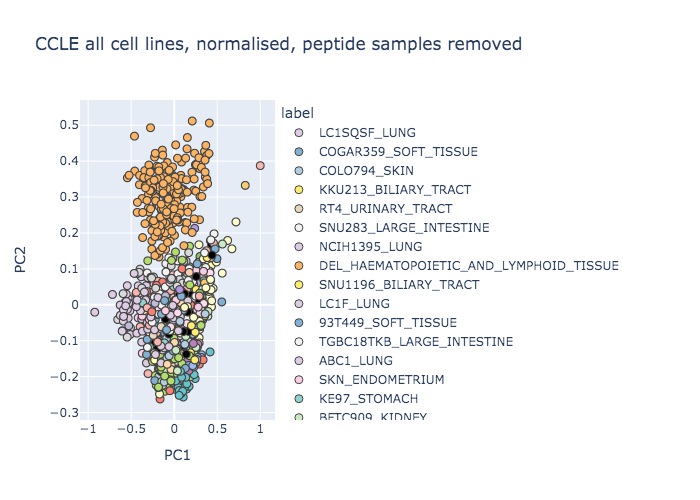

In [58]:
from IPython.display import Image
Image(img_bytes)

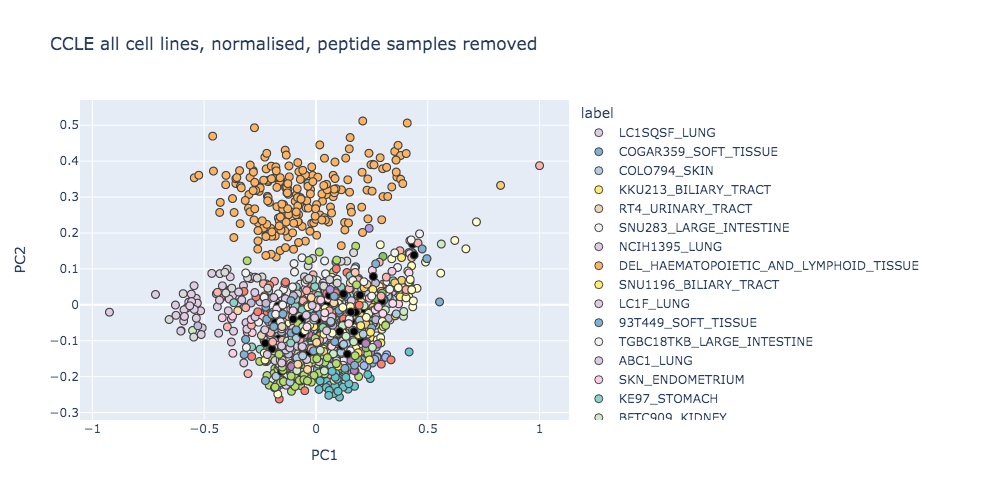

In [63]:
img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [ ]:
#can just send myself the proteomics and do it on here